In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings, sys, os, random


SEED = 42
np.random.seed(SEED)
random.seed(SEED)



In [2]:
import sklearn
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("XGBoost:", xgb.__version__)

Python: 3.12.9
NumPy: 2.3.3
Pandas: 2.3.2
scikit-learn: 1.7.2
XGBoost: 3.0.1


In [ ]:
# Step 1: Load your SAIL dataset
import pandas as pd

# Load the CSV file (use your actual file path if different)
df = pd.read_csv("SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv")

# Step 2: Define features (X) and a single target (y)
# Features = time-related columns
X = df[["hour", "minute", "day", "weekday", "is_weekend"]]

# --- NEW PART ---
# Select one specific sensor column as the prediction target
# You can manually change the name below to any column you want to test
TARGET_SENSOR = "GASA-06_95"   # <- replace with your actual sensor column name
y = df[TARGET_SENSOR]
# --- END ---

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Selected target sensor:", TARGET_SENSOR)

# Optional: preview
display(df[[TARGET_SENSOR]].head(3))


Shape of X: (2400, 5)
Shape of y: (2400,)
Selected target sensor: GVCV-09_80


,GVCV-09_80
0,0
1,0
2,0


In [4]:
# ===== 3) Add lag features for the selected sensor =====
import pandas as pd

def create_lag_features(series: pd.Series, lags) -> pd.DataFrame:
    """
    Build lag features from a target series.
    Each lag k creates a column: <series.name>_lag{k} = series.shift(k)
    """
    lag_df = pd.concat({f"{series.name}_lag{k}": series.shift(k) for k in lags}, axis=1)
    return lag_df

# Choose how many past steps to include as predictors
# Each "step" corresponds to one row in your dataset (e.g., 3 minutes in your file)
LAG_STEPS = [1, 2, 3, 4, 5, 6]  # start simple; you can test [1,2,3] first if you like

# 1) Create lag features for the selected target sensor
lag_features = create_lag_features(df[TARGET_SENSOR], LAG_STEPS)

# 2) Concatenate time features (X) with lag features
X_lagged = pd.concat([X, lag_features], axis=1)

# 3) Align X and y by dropping rows with NaNs introduced by shifting
aligned = pd.concat([X_lagged, y], axis=1).dropna()

# 4) Final matrices for modeling
X_final = aligned[X_lagged.columns]
y_final = aligned[TARGET_SENSOR]

print("X_final shape:", X_final.shape)
print("y_final shape:", y_final.shape)
display(X_final.head(3))


X_final shape: (2394, 11)
y_final shape: (2394,)


,hour,minute,day,weekday,is_weekend,GVCV-09_80_lag1,GVCV-09_80_lag2,GVCV-09_80_lag3,GVCV-09_80_lag4,GVCV-09_80_lag5,GVCV-09_80_lag6
6,0,18,20,2,0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,21,20,2,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,24,20,2,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# ===== 4) Time-based split =====
# Keep chronological order; do NOT shuffle for time series
test_ratio = 0.2
test_size = int(len(X_final) * test_ratio)

X_train, X_test = X_final.iloc[:-test_size], X_final.iloc[-test_size:]
y_train, y_test = y_final.iloc[:-test_size], y_final.iloc[-test_size:]

print("Train size:", X_train.shape, y_train.shape)
print("Test size :", X_test.shape, y_test.shape)


Train size: (1916, 11) (1916,)
Test size : (478, 11) (478,)


In [6]:
# ===== 5) Train XGBoost regressor =====
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"   # good default on CPU
)

xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
# ===== 6) Predict and evaluate =====
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# Compute RMSE in a version-agnostic way
mse  = mean_squared_error(y_test, y_pred)      # squared=True by default
rmse = np.sqrt(mse)

print(f"R2:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


R2:   -0.3223
MAE:  0.0842
RMSE: 0.3259


In [8]:
# ===== 7) Naive baseline (persistence) for reference =====
# Predict the next value equals the last observed value (lag-1)
naive_pred = X_test[f"{TARGET_SENSOR}_lag1"].values

r2_naive  = r2_score(y_test, naive_pred)
mae_naive = mean_absolute_error(y_test, naive_pred)
mse_naive  = mean_squared_error(y_test, naive_pred)
rmse_naive = np.sqrt(mse_naive)

print("[Naive baseline]")
print(f"R2:   {r2_naive:.4f}")
print(f"MAE:  {mae_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")


[Naive baseline]
R2:   -0.7190
MAE:  0.0586
RMSE: 0.3716


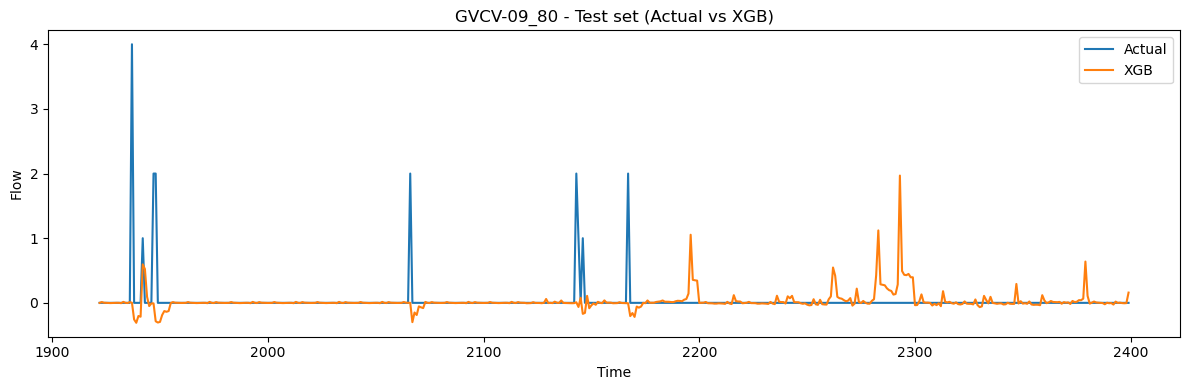

In [9]:
# ===== 8) Quick plot (actual vs prediction on test set) =====
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="XGB")
plt.legend()
plt.title(f"{TARGET_SENSOR} - Test set (Actual vs XGB)")
plt.xlabel("Time")
plt.ylabel("Flow")
plt.tight_layout()
plt.show()


In [10]:
# ==== Utilities for time series CV with a gap and for metrics ====
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def time_split_with_gap(X: pd.DataFrame,
                        y: pd.Series,
                        test_ratio: float = 0.2,
                        gap: int = 0):
    """
    Split a time-series dataset into training and validation sets,
    leaving a gap period between them to prevent data leakage from lag features.

    Parameters:
        X : pd.DataFrame
            Feature matrix sorted in chronological order.
        y : pd.Series
            Target series aligned with X.
        test_ratio : float, optional (default=0.2)
            Proportion of samples used for the validation set.
        gap : int, optional (default=0)
            Number of observations to skip between train and validation sets.

    Returns:
        X_train, X_valid, y_train, y_valid
    """
    n = len(X)
    test_size = int(n * test_ratio)
    # The split point is set before the validation set, leaving the gap
    split_point = n - test_size - gap
    if split_point <= 0:
        raise ValueError(f"split_point <= 0, reduce test_ratio or gap. n={n}, test_size={test_size}, gap={gap}")

    X_train = X.iloc[:split_point]
    y_train = y.iloc[:split_point]
    # Validation set starts after the gap until the end
    X_valid = X.iloc[split_point + gap:]
    y_valid = y.iloc[split_point + gap:]
    return X_train, X_valid, y_train, y_valid


def evaluate_preds(y_true, y_pred):
    """
    Evaluate model predictions using common regression metrics.

    Returns:
        r2   : R² score
        mae  : Mean Absolute Error
        rmse : Root Mean Squared Error
    """
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse


In [11]:
# ===== Optuna: also optimize the number of lags (max_lag) =====
import optuna
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# cache to avoid rebuilding features for the same max_lag repeatedly
_LAG_CACHE = {}  # key: max_lag -> (X_final, y_final)

def build_dataset_with_lags(max_lag: int) -> tuple[pd.DataFrame, pd.Series]:
    """
    Build X_final, y_final for a given max_lag and cache the result.
    Lags used are contiguous: 1..max_lag.
    """
    if max_lag in _LAG_CACHE:
        return _LAG_CACHE[max_lag]

    # 1) lag block
    lag_features = create_lag_features(df[TARGET_SENSOR], range(1, max_lag + 1))
    # 2) concat time features + lags
    X_lagged = pd.concat([X, lag_features], axis=1)
    # 3) align and drop NaNs due to shift
    aligned = pd.concat([X_lagged, y], axis=1).dropna()
    X_final = aligned[X_lagged.columns]
    y_final = aligned[TARGET_SENSOR]

    _LAG_CACHE[max_lag] = (X_final, y_final)
    return X_final, y_final

def objective(trial: optuna.Trial) -> float:
    """
    Jointly optimize:
      - max_lag (how many past steps to include)
      - key XGBoost hyperparameters
    Target: maximize R2 on a chronological validation split with a leakage-safe gap.
    """
    # --- search space ---
    max_lag = trial.suggest_int("max_lag", 3, 12)  # adjust bounds to your cadence/horizon

    params = dict(
        n_estimators     = trial.suggest_int("n_estimators", 300, 1000),
        learning_rate    = trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        max_depth        = trial.suggest_int("max_depth", 3, 9),
        min_child_weight = trial.suggest_int("min_child_weight", 1, 12),
        subsample        = trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0),
        gamma            = trial.suggest_float("gamma", 0.0, 3.0),
        reg_lambda       = trial.suggest_float("reg_lambda", 0.0, 10.0),
        reg_alpha        = trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state     = 42,
        tree_method      = "hist",
    )

    # --- dataset for this lag setting (cached) ---
    Xf, yf = build_dataset_with_lags(max_lag)

    # chronological split; gap = max_lag to be safe
    X_train, X_valid, y_train, y_valid = time_split_with_gap(Xf, yf, test_ratio=0.2, gap=max_lag)

    # --- fit & eval ---
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    r2, mae, rmse = evaluate_preds(y_valid, y_pred)

    # store aux metrics to the trial
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("n_valid", len(y_valid))

    return r2  # maximize



In [12]:
# ===== Run study =====
study = optuna.create_study(direction="maximize", study_name="xgb_sail_joint_lag")
study.optimize(objective, n_trials=40, show_progress_bar=True)  # start with 30-40; scale up if needed

print("Best R2:", f"{study.best_value:.4f}")
print("Best params:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

print("\nAux metrics (best trial):")
print("  MAE :", f"{study.best_trial.user_attrs['mae']:.4f}")
print("  RMSE:", f"{study.best_trial.user_attrs['rmse']:.4f}")
print("  n_valid:", study.best_trial.user_attrs['n_valid'])


[I 2025-11-06 14:14:54,067] A new study created in memory with name: xgb_sail_joint_lag


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-06 14:14:54,192] Trial 0 finished with value: 0.0003541707992553711 and parameters: {'max_lag': 4, 'n_estimators': 497, 'learning_rate': 0.0013425461732985396, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7393302264157041, 'colsample_bytree': 0.7637240842854377, 'gamma': 2.837630675640164, 'reg_lambda': 1.7443269503970193, 'reg_alpha': 1.7964186462027576}. Best is trial 0 with value: 0.0003541707992553711.
[I 2025-11-06 14:14:54,395] Trial 1 finished with value: 0.01672452688217163 and parameters: {'max_lag': 11, 'n_estimators': 833, 'learning_rate': 0.08736312565876653, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9755525912460047, 'colsample_bytree': 0.9296880305167228, 'gamma': 0.9922578050788359, 'reg_lambda': 2.873973051400073, 'reg_alpha': 0.9022921042899397}. Best is trial 1 with value: 0.01672452688217163.
[I 2025-11-06 14:14:54,541] Trial 2 finished with value: 0.01641690731048584 and parameters: {'max_lag': 7, 'n_estimators': 584, 'learning_rate'

In [13]:
# ===== Train final model with the best max_lag and best hyperparams =====
best = study.best_trial.params
best_max_lag = best.pop("max_lag")  # separate lag count from model params

Xf_best, yf_best = build_dataset_with_lags(best_max_lag)
X_train, X_valid, y_train, y_valid = time_split_with_gap(Xf_best, yf_best, test_ratio=0.2, gap=best_max_lag)

best_model = XGBRegressor(**best, random_state=42, tree_method="hist")
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_valid)

r2, mae, rmse = evaluate_preds(y_valid, y_pred_best)
print("\n[Final evaluation with best max_lag]")
print("max_lag:", best_max_lag)
print("R2  :", f"{r2:.4f}")
print("MAE :", f"{mae:.4f}")
print("RMSE:", f"{rmse:.4f}")

# naive baseline on the same validation set (persistence)
naive_pred = X_valid[f"{TARGET_SENSOR}_lag1"].values
r2_b, mae_b, rmse_b = evaluate_preds(y_valid, naive_pred)
print("\n[Naive baseline]")
print("R2  :", f"{r2_b:.4f}")
print("MAE :", f"{mae_b:.4f}")
print("RMSE:", f"{rmse_b:.4f}")




[Final evaluation with best max_lag]
max_lag: 12
R2  : 0.0206
MAE : 0.0555
RMSE: 0.2808

[Naive baseline]
R2  : -0.7190
MAE : 0.0587
RMSE: 0.3720


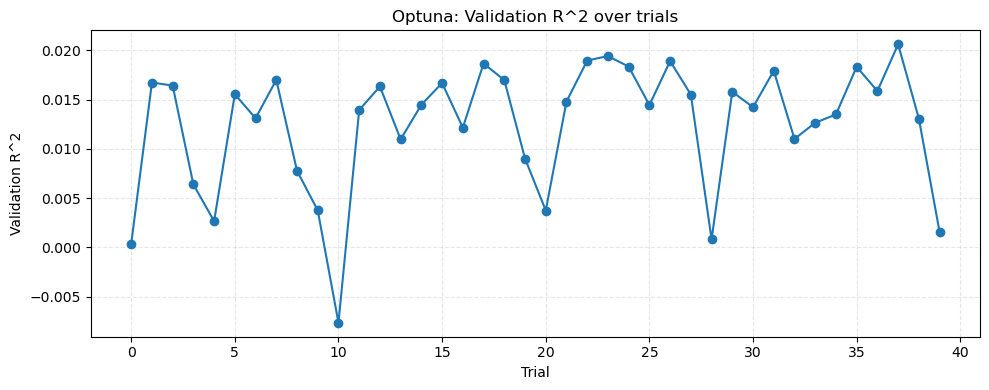

In [14]:
# ===== Viz 1: Optuna optimization history (trial vs R2) =====
import matplotlib.pyplot as plt

# collect R2 per trial
trial_nums = [t.number for t in study.trials if t.value is not None]
trial_values = [t.value for t in study.trials if t.value is not None]

plt.figure(figsize=(10, 4))
plt.plot(trial_nums, trial_values, marker="o")
plt.title("Optuna: Validation R^2 over trials")
plt.xlabel("Trial")
plt.ylabel("Validation R^2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


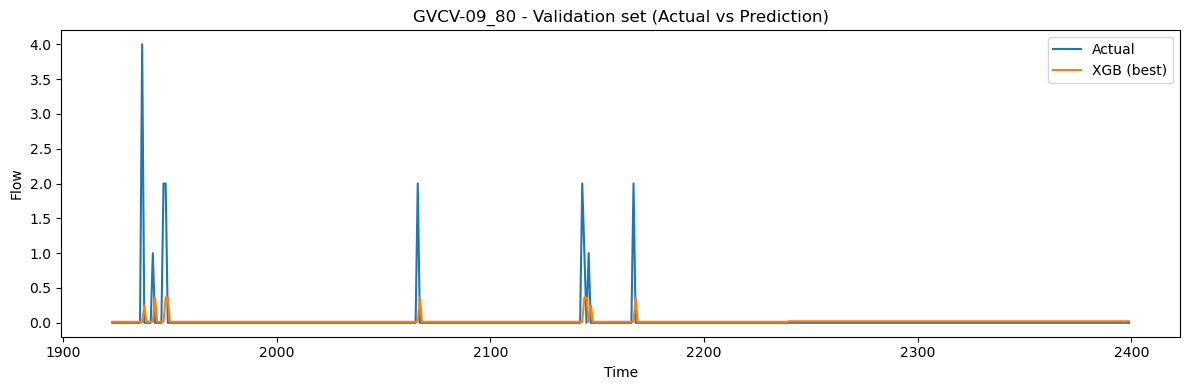

In [15]:
# ===== Viz 2: Best model - Actual vs Predicted on validation set =====
plt.figure(figsize=(12, 4))
plt.plot(y_valid.index, y_valid.values, label="Actual")
plt.plot(y_valid.index, y_pred_best, label="XGB (best)")
plt.title(f"{TARGET_SENSOR} - Validation set (Actual vs Prediction)")
plt.xlabel("Time")
plt.ylabel("Flow")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals (y - y_hat)
resid = y_valid.values - y_pred_best


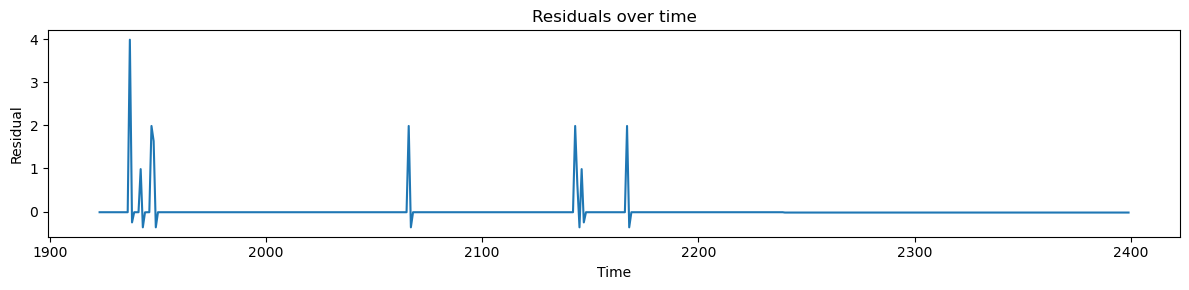

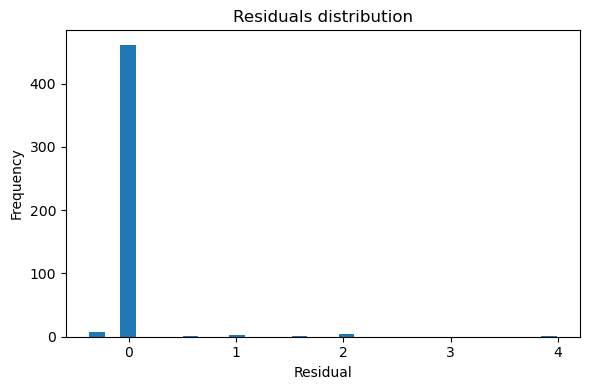

In [16]:
# ===== Viz 3: Residual diagnostics =====
# 3a) Residuals over time
plt.figure(figsize=(12, 3))
plt.plot(y_valid.index, resid)
plt.title("Residuals over time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 3b) Residuals histogram
plt.figure(figsize=(6, 4))
plt.hist(resid, bins=30)
plt.title("Residuals distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


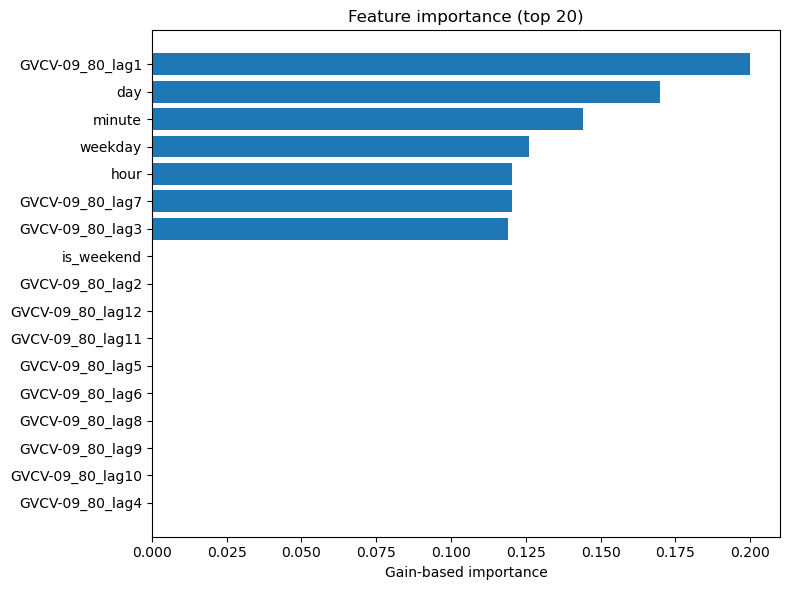

In [17]:
# ===== Viz 4: Feature importance (XGBoost) =====
import numpy as np
import pandas as pd

# get feature importances from the trained best model
fi = best_model.feature_importances_
feat_names = list(X_train.columns)

fi_df = pd.DataFrame({"feature": feat_names, "importance": fi})
fi_df = fi_df.sort_values("importance", ascending=True).tail(20)  # top 20

plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.title("Feature importance (top 20)")
plt.xlabel("Gain-based importance")
plt.tight_layout()
plt.show()
